Pre-Processing of Data

In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
#Loading Input Data
data_frame = pd.read_csv("shuffled-full-set-hashed.csv",header=None);
data_frame.head()

,0,1
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


In [3]:
# Total length of document including NAN values in CSV File
len(data_frame)

62204

In [4]:
# Dropping all the NAN values in CSV File
data_frame.dropna(inplace = True)
#Printing the updated length
len(data_frame)

62159

In [5]:
#List of Labels in CSV
unique_labels = set(data_frame[0].values.tolist())
unique_labels

{'APPLICATION',
 'BILL',
 'BILL BINDER',
 'BINDER',
 'CANCELLATION NOTICE',
 'CHANGE ENDORSEMENT',
 'DECLARATION',
 'DELETION OF INTEREST',
 'EXPIRATION NOTICE',
 'INTENT TO CANCEL NOTICE',
 'NON-RENEWAL NOTICE',
 'POLICY CHANGE',
 'REINSTATEMENT NOTICE',
 'RETURNED CHECK'}

In [6]:
# Complete labels in Document
labels = data_frame[0].values.tolist()

In [7]:
# All encoded text keyword in document
text = data_frame[1].values.tolist()

In [8]:
# Create training and testing
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.3)

In [9]:
# Appending all the encoded words together
all_words = []
for string in X_train:
    all_words+= (string.split(" "))

In [10]:
# Frequency Calculation 
freq = nltk.FreqDist(all_words)

In [11]:
# Picking the top 250 frequent Words
common = freq.most_common(250)

In [12]:
# Features Extraction
features = [i[0] for i in common]

In [13]:
# Write the features set to disk using pickle
import pickle
# save the features
with open('features.pkl', 'wb') as fid:
    pickle.dump(features, fid)

In [14]:
# Function to Get Features of every Row and returns Dictionary which represents,
# how many frequent words are present in that row 
def get_feature_dict(words):
    current_features = {}
    words_set = set(words)
    for w in features:
        current_features[w] = w in words_set
    return current_features

In [15]:
# Recreating the training set and testing set in forms of an array
training_set = []
for i in range(len(X_train)):
    training_set.append(((X_train[i]),y_train[i]))
testing_set = []
for i in range(len(X_test)):
    testing_set.append(((X_test[i]),y_test[i]))

In [16]:
# An Array of Dictionary of Training Set
# Dictionary has the key of features where values represent if the encoded text is present in this row or not.
# With correct Labels append on the array
training_data = [(get_feature_dict(string.split(" ")), category) for string,category in training_set]

In [17]:
# An Array of Dictionary of Testing Set
# Dictionary has the key of features where values represent if the encoded text is present in this row or not.
# With correct Labels append on the array
testing_data = [(get_feature_dict(string.split(" ")), category) for string, category in testing_set]

Random Search Training For Best Parameters

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Random Hyperparameter Grid

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


Random Search Training

In [20]:
# Function to get Feature Array of Any Row in document
def get_features_Array(words):
    current_features = []
    words_set = set(words)
    for w in features:
        current_features.append(w in words_set)
    return current_features

In [21]:
All_Features_X = [(get_features_Array(string.split(" "))) for string in X_train]

In [22]:
# from sklearn.model_selection import RandomizedSearchCV
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 100, cv = 5)
# # Fit the random search model
# # 300 colum along all rows in document
# All_Features_X = [(get_features_Array(string.split(" "))) for string in X_train]
# rf_random.fit(All_Features_X,y_train)
# rf_random.best_params_

In [23]:
from nltk.classify.scikitlearn import SklearnClassifier
from time import time

In [24]:
# Starting Time
start = time()
# Classifier with Best Params Value found in 
rfc = RandomForestClassifier(n_estimators=90,min_samples_split=5,min_samples_leaf=2,max_features='auto',bootstrap=False)
RFC_classifier = SklearnClassifier(rfc)

In [25]:
RFC_classifier.train(training_data)
print((time() - start))

144.1378788948059


In [26]:
start = time()
print("Random Forest accuracy percent:", (nltk.classify.accuracy(RFC_classifier, testing_data))*100)
print((time() - start))

Random Forest accuracy percent: 86.70634920634922
4.0990400314331055


In [27]:
start = time()
rfc_without_params = RandomForestClassifier()
RFC_classifier_no_params = SklearnClassifier(rfc_without_params)
RFC_classifier_no_params.train(training_data)
print((time() - start))
start = time()
print("Random Forest accuracy without params percent:", (nltk.classify.accuracy(RFC_classifier_no_params, testing_data))*100)
print((time() - start))

26.447569847106934
Random Forest accuracy without params percent: 84.28249678249678
3.3500161170959473


Saving Trained Classifier To Disk

In [28]:
# save the classifier
with open('rfc.pkl', 'wb') as fid:
    pickle.dump(RFC_classifier, fid)
with open('rfc1.pkl', 'wb') as fid:
    pickle.dump(RFC_classifier_no_params, fid)

In [29]:
# Ignoring SVM since it is taking to much time on testing and Training
#from sklearn.svm import SVC
#from nltk.classify.scikitlearn import SklearnClassifier

In [30]:
#start = time()
#svc = SVC(gamma=0.001, C=10)
#SVC_classifier = SklearnClassifier(svc)

In [31]:
#Ignorong SVM since it is taking 
#SVC_classifier.train(training_data)

In [32]:
#print("SVM accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_data))*100)
#print((time() - start))

In [33]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [34]:
start = time()
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_data)
print("MultinomialNB accuracy percent:",(nltk.classify.accuracy(MNB_classifier, testing_data))*100)
print((time() - start))

MultinomialNB accuracy percent: 70.63492063492063
11.16794204711914


In [35]:
start = time()
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_data)
print("BernoulliNB accuracy percent:",(nltk.classify.accuracy(BNB_classifier, testing_data))*100)
print((time() - start))

BernoulliNB accuracy percent: 67.58901758901759
9.761381149291992


In [36]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

In [37]:
start = time()
LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_data)
print((time() - start))
start = time()
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_data))*100)
print((time() - start))

28.370112895965576
LogisticRegression_classifier accuracy percent: 82.81853281853282
2.9599337577819824


In [38]:
start = time()
LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_data)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_data))*100)
print((time() - start))

LinearSVC_classifier accuracy percent: 82.66838266838266
63.8689980506897


Confusion Matrix

In [39]:
# Getting Array of Dictionary of Testing Data Set
# Dictionary Represent the Features of Testing Set
testing_dict_X = [(get_feature_dict(string.split(" "))) for string, category in testing_set]

In [40]:
# Getting Array of Labels on Testing Set
testing_Y = [category for string, category in testing_set]

In [41]:
# Predicted Value From Classifier
y_pred = RFC_classifier.classify_many(testing_dict_X)

In [42]:
# Function to Print Confusion Matrix
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(35,22)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

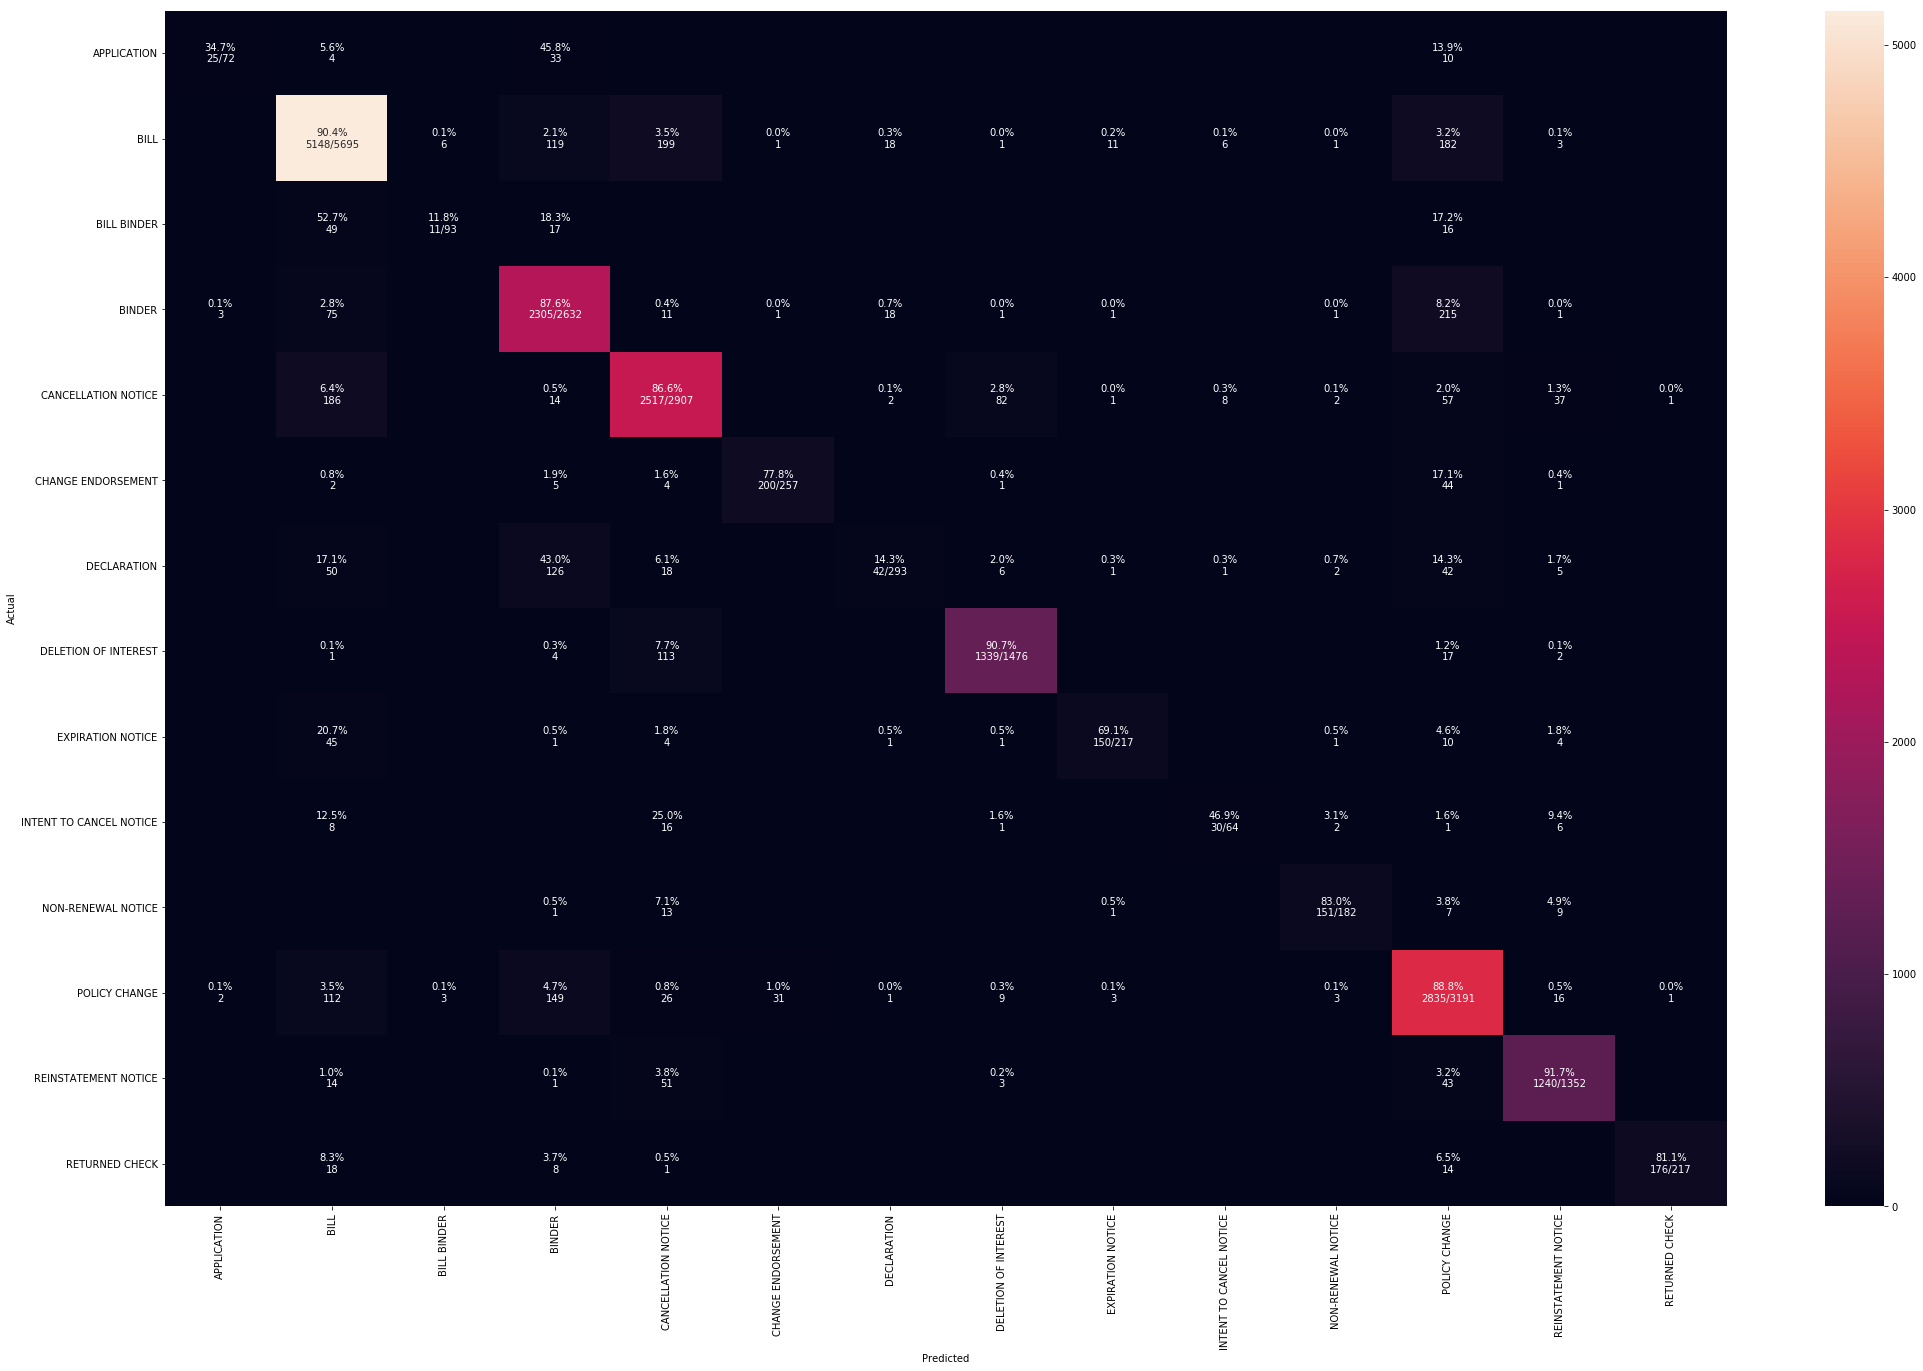

In [43]:
# Print Confusion Matrix
unique_label = np.unique(testing_Y)
cm_analysis(testing_Y,y_pred,unique_label)